## **Library**

In [1]:
# ========= Basic Utilities and System Setup =========
import os
import sys
import time

# ========= Data Handling =========
import numpy as np
import pandas as pd
from scipy.stats import uniform, randint

# ========= Machine Learning =========
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import (
    confusion_matrix, accuracy_score, f1_score, roc_auc_score,
    average_precision_score, roc_curve, precision_recall_curve
)
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

# ========= Tools and Visualization =========
from tqdm import tqdm
import shap
from joblib import dump, load

# ========= Custom Modules =========
# Add custom module path
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.insert(0, src_path)

from config import data_dir, cache_dir, output_dir
from model_utils import (
    custom_classify,
    get_metrics,
    PlotConfusionMatrix,
    imputer,
    scaling,
)

from compare_auc_delong_xu import delong_roc_test


## **Settings**

In [2]:
random_seed= 564
class_weights = {0: 1, 1: 1, 2:1}
"""
class_1_threshold= 0.037
class_2_threshold= 0.023
class_0_threshold= 0.940
"""
class_1_threshold= 0.051
class_2_threshold= 0.019
class_0_threshold= 0.921

impute_method = 'mean'


## **Assign Variables**

In [24]:
# Load data 
data = pd.read_csv(
    os.path.join(data_dir, 'CMUH_GS_2021_triage.csv'),
)

data_test = pd.read_csv(
    os.path.join(data_dir, 'CMUH_GS_2023_triage.csv'),
)

# Load external validation datasets from AN and WMH hospitals
data_AN = pd.read_csv(
    os.path.join(data_dir, 'AN_GS_2023.csv'),
)

data_WK = pd.read_csv(
    os.path.join(data_dir, 'WK_GS_2023.csv'),
)

In [26]:
y = data.loc[:,'final_label']
x = data.iloc[:,6:93]

y_test = data_test.loc[:,'final_label']
x_test = data_test.iloc[:,6:93]

y_wk = data_WK.loc[:,'final_label']
x_wk = data_WK.iloc[:,6:93]

y_an = data_AN.loc[:,'final_label']
x_an = data_AN.iloc[:,6:93]

x_base = data[['SIRS']]
x_test_base = data_test[['SIRS']]

In [5]:
from collections import Counter

for i in [y, y_test, y_wk, y_an] :
    element_counts = Counter(i)
    total_elements = len(i)
    # 打印结果
    print(f"total case: {total_elements}")
    print("Counts of 0:", element_counts[0])
    print("Counts of 1:", element_counts[1])
    print("Counts of 2:", element_counts[2])


    # 计算各个元素的比例
    element_proportions = {key: count / total_elements for key, count in element_counts.items()}
    
    # 打印各个元素的比例
    for key, proportion in element_proportions.items():
        print(f"Proportion of {key}: {proportion:.2%}")


total case: 28503
Counts of 0: 25534
Counts of 1: 2174
Counts of 2: 795
Proportion of 2: 2.79%
Proportion of 1: 7.63%
Proportion of 0: 89.58%
total case: 15801
Counts of 0: 14387
Counts of 1: 997
Counts of 2: 417
Proportion of 1: 6.31%
Proportion of 0: 91.05%
Proportion of 2: 2.64%
total case: 2632
Counts of 0: 2415
Counts of 1: 173
Counts of 2: 44
Proportion of 2: 1.67%
Proportion of 1: 6.57%
Proportion of 0: 91.76%
total case: 3811
Counts of 0: 3556
Counts of 1: 185
Counts of 2: 70
Proportion of 2: 1.84%
Proportion of 1: 4.85%
Proportion of 0: 93.31%


## **Statistics**

#### **Missing rate**

In [9]:
cohorts = {
    'Development (CMUH)': data,
    'Internal Test (CMUH)': data_test,
    'External (WMH)': data_WK,
    'External (ANH)': data_AN
}

# 計算每個 cohort 中每一欄的 missing 數量與比例
missing_summary = []

for name, df in cohorts.items():
    total = len(df)
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / total * 100).round(2)
    for col in df.columns:
        if missing_count[col] > 0:
            missing_summary.append({
                'Cohort': name,
                'Variable': col,
                'Missing Count': missing_count[col],
                'Missing %': missing_percent[col]
            })

# 整理為表格
missing_df = pd.DataFrame(missing_summary)
missing_df = missing_df.sort_values(by=['Cohort', 'Missing %'], ascending=[True, False])

# 顯示前幾列
print(missing_df.head(10))

                Cohort     Variable  Missing Count  Missing %
12  Development (CMUH)          MDW           1511       5.30
78  Development (CMUH)          SBP           1212       4.25
79  Development (CMUH)          DBP           1212       4.25
80  Development (CMUH)           HR           1104       3.87
19  Development (CMUH)    MN_AL2_EO            698       2.45
23  Development (CMUH)      MN_C_EO            698       2.45
27  Development (CMUH)   MN_LALS_EO            698       2.45
31  Development (CMUH)  MN_LMALS_EO            698       2.45
35  Development (CMUH)   MN_MALS_EO            698       2.45
39  Development (CMUH)  MN_UMALS_EO            698       2.45


#### **統計blood culture是在CBC 多久後抽取**

統計摘要（單位：小時）：
count    28503.000000
mean        -0.082478
std          2.278543
min        -11.990278
25%         -0.668611
50%         -0.440000
75%         -0.283611
max         11.988611
Name: bloodcx_duration_12_1, dtype: float64

各時間區間比例：
< -6 hr: 197 (0.69%)
-6 ~ -2 hr: 822 (2.88%)
-2 ~ 0 hr: 24404 (85.62%)
0–6 hr: 1937 (6.8%)
6–12 hr: 1143 (4.01%)
12–24 hr: 0 (0.0%)
24–48 hr: 0 (0.0%)
48–72 hr: 0 (0.0%)
>72 hr: 0 (0.0%)


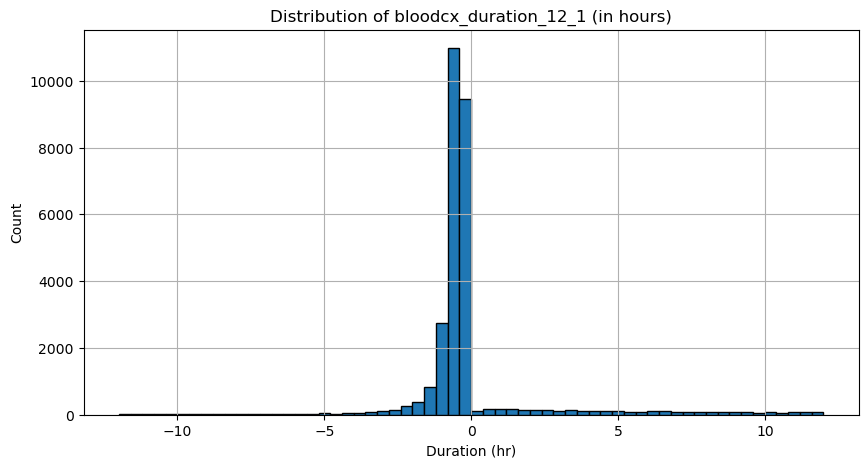

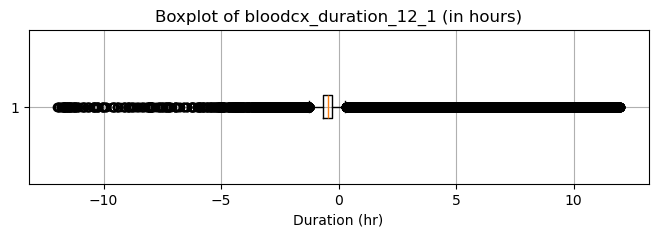

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: 轉換字串為 timedelta，再換算成小時
duration_str = data['bloodcx_duration_12_1'].dropna()
duration_timedelta = pd.to_timedelta(duration_str, errors='coerce')
duration_hours = duration_timedelta.dt.total_seconds() / 3600
duration_hours = duration_hours.dropna()

# Step 2: 統計摘要
summary = duration_hours.describe()
print("統計摘要（單位：小時）：")
print(summary)

# Step 3: 設定分組區間（含負值細分）
bins = [-float('inf'), -6, -2, 0, 6, 12, 24, 48, 72, float('inf')]
labels = ['< -6 hr', '-6 ~ -2 hr', '-2 ~ 0 hr', '0–6 hr', '6–12 hr', '12–24 hr', '24–48 hr', '48–72 hr', '>72 hr']

# Step 4: 分組統計
duration_groups = pd.cut(duration_hours, bins=bins, labels=labels, include_lowest=True)
group_counts = duration_groups.value_counts().sort_index()
group_percent = (group_counts / len(duration_hours) * 100).round(2)

print("\n各時間區間比例：")
for label in labels:
    print(f"{label}: {group_counts[label]} ({group_percent[label]}%)")

# Step 5: 繪圖
# 直方圖
plt.figure(figsize=(10, 5))
plt.hist(duration_hours, bins=60, edgecolor='black')
plt.title('Distribution of bloodcx_duration_12_1 (in hours)')
plt.xlabel('Duration (hr)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# 箱型圖
plt.figure(figsize=(8, 2))
plt.boxplot(duration_hours, vert=False)
plt.title('Boxplot of bloodcx_duration_12_1 (in hours)')
plt.xlabel('Duration (hr)')
plt.grid(True)
plt.show()


> CBC是用report time, blood culture 適用Draw time, 本身時間就差了一點

#### **Comorbidity**

In [35]:
data_test['CAD']

0          NaN
1          NaN
2          NaN
3          NaN
4        False
         ...  
15796    False
15797    False
15798    False
15799    False
15800    False
Name: CAD, Length: 15801, dtype: object

In [33]:
# 定義 comorbidities 的 pattern 字典
comorbidity_patterns = {
    'DM': r'\b(?:T2DM|DM|D/M|Diabetes|糖尿病)[\s,，]?',
    'HTN':  r'(?<!pulmonary\s)\b(?:HTN|H/T|Hypertension|高血壓)[\s,，]?',
    'Liver_Cirrhosis': r'\b(?:L/C|liver cirrhosis|肝硬化)[\s,，]?',
    'COPD': r'\b(?:COPD|阻塞性肺病)[\s,，]?',
    'ESRD': r'(?:\b(?:ESRD|H/D|P/D|HD|PD)\b|洗腎|透析|末期腎衰竭)',
    'HIV': r'\b(?:HIV|AIDS|愛滋)[\s,，]?',
    'Cancer': r'(?:cancer|leukemia|lymphoma|惡性腫瘤|癌)',
    'Heart_Disease': r'\b(?:heart disease)[\s,，]?',
    'CAD': r'\b(?:CAD|心肌梗塞|STEMI|冠狀動脈)[\s,，]?'
}


# 自動產生布林欄位
for label, pattern in comorbidity_patterns.items():
    print(f"{label}")
    col_name = f'{label}'
    data_test[col_name] = data_test['Past_history'].str.contains(pattern, case=False, regex=True)


DM
HTN
Liver_Cirrhosis
COPD
ESRD
HIV
Cancer
Heart_Disease
CAD


In [42]:
# 總樣本數
total_rows = len(data_test)

# 建立結果儲存表
summary = []

for label, pattern in comorbidity_patterns.items():
    print (label)
    col_name = f'{label}'
    true_count = data_test[col_name].sum()
    percentage = true_count / len(data_test) * 100
    summary.append({
        'Comorbidity': label,
        'True_Count': true_count,
        'Percentage': f"{percentage:.1f}%"
    })

# 顯示統計結果表格
import pandas as pd
summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values(by='True_Count', ascending=False).reset_index(drop=True)

summary_df


DM
HTN
Liver_Cirrhosis
COPD
ESRD
HIV
Cancer
Heart_Disease
CAD


,Comorbidity,True_Count,Percentage
0,HTN,5046,31.9%
1,DM,3629,23.0%
2,Cancer,2312,14.6%
3,Heart_Disease,2092,13.2%
4,ESRD,787,5.0%
5,CAD,452,2.9%
6,Liver_Cirrhosis,176,1.1%
7,HIV,47,0.3%
8,COPD,46,0.3%


In [41]:
check = data_test[["Past_history","HTN", "DM", "ESRD", "Cancer"]]
check

,Past_history,HTN,DM,ESRD,Cancer
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,"護理:liver disease,OP history,其他。 醫囑:其他：as chart。",False,False,False,False
...,...,...,...,...,...
15796,"護理:H/T,heart disease,其他。 醫囑:無。",True,False,False,False
15797,護理:其他。 醫囑:無。,False,False,False,False
15798,護理:其他。 醫囑:其他：as chart。,False,False,False,False
15799,"護理:heart disease,Cancer disease,OP history,其他。...",False,False,False,True


#### **統計菌種**

In [102]:
# 建立結果儲存清單

df= data_test.copy()
target_class = 1
bac_all = []
for i in range(1, 9):
    sub_label_col = f'bloodcx_36_{i}_sub_label'
    if sub_label_col in df.columns:
        bac_cols = [f'bloodcx_36_{i}_bac_1', f'bloodcx_36_{i}_bac_2', f'bloodcx_36_{i}_bac_3']
        for col in bac_cols:
            subset = df[df[sub_label_col] == target_class][['Sample_ID', 'final_label', 'predictions', col]].copy()
            subset = subset.rename(columns={col: 'bac'})
            bac_all.append(subset)

# 合併資料
bac_df = pd.concat(bac_all, ignore_index=True)

# 去除無效資料
bac_df = bac_df[bac_df['bac'].notna()]
bac_df = bac_df[~bac_df['bac'].isin(['no bac', '', ' '])]
# 同一病患同一菌種只保留一次
dedup_df = bac_df.drop_duplicates(subset=['Sample_ID','bac']).reset_index(drop=True)

# 計算 match (final_label == predictions)
dedup_df.loc[:, 'match'] = dedup_df['final_label'] == dedup_df['predictions']
# 計算 bacteremia_match：若 prediction 為 1 或 2 就算正確
dedup_df.loc[:, 'bacteremia_match'] = dedup_df['predictions'].isin([1, 2])


# 聚合統計
summary_df = dedup_df.groupby('bac').agg(
    count=('Sample_ID', 'count'),
    accuracy=('match', 'mean'),
    bacteremia_accuracy=('bacteremia_match', 'mean')
).reset_index()

# 百分比格式化可選
# summary_df['accuracy'] = summary_df['accuracy'] * 100
# summary_df['bacteremia_accuracy'] = summary_df['bacteremia_accuracy'] * 100

summary_df

,bac,count,accuracy,bacteremia_accuracy
0,Achromobacter xylosoxidans,2,0.5,1.0
1,Acinetobacter baumannii,10,0.4,1.0
2,Acinetobacter baumannii/calcoaceticus complex,2,1.0,1.0
3,Acinetobacter junii,1,0.0,1.0
4,Acinetobacter lwoffii,2,1.0,1.0
...,...,...,...,...
102,Streptococcus anginosus,2,1.0,1.0
103,Streptococcus constellatus,2,1.0,1.0
104,Streptococcus mitis group,1,1.0,1.0
105,Streptococcus oralis,1,1.0,1.0


In [ ]:
# 建立結果儲存清單

df= data.copy()
target_class = 1
bac_all = []
for i in range(1, 9):
    sub_label_col = f'bloodcx_36_{i}_sub_label'
    if sub_label_col in df.columns:
        bac_cols = [f'bloodcx_36_{i}_bac_1', f'bloodcx_36_{i}_bac_2', f'bloodcx_36_{i}_bac_3']
        for col in bac_cols:
            subset = df[df[sub_label_col] != -1][['Sample_ID', 'final_label', 'predictions', col]].copy()
            subset = subset.rename(columns={col: 'bac'})
            bac_all.append(subset)

# 合併資料
bac_df = pd.concat(bac_all, ignore_index=True)

# 去除無效資料
bac_df = bac_df[bac_df['bac'].notna()]
bac_df = bac_df[~bac_df['bac'].isin(['no bac', '', ' '])]
# 同一病患同一菌種只保留一次
dedup_df = bac_df.drop_duplicates(subset=['Sample_ID','bac']).reset_index(drop=True)

# 計算 match (final_label == predictions)
dedup_df.loc[:, 'match'] = dedup_df['final_label'] == dedup_df['predictions']
# 計算 bacteremia_match：若 prediction 為 1 或 2 就算正確
dedup_df.loc[:, 'bacteremia_match'] = dedup_df['predictions'].isin([1, 2])


# 聚合統計
summary_df = dedup_df.groupby('bac').agg(
    count=('Sample_ID', 'count'),
    accuracy=('match', 'mean'),
    bacteremia_accuracy=('bacteremia_match', 'mean')
).reset_index()

# 百分比格式化可選
# summary_df['accuracy'] = summary_df['accuracy'] * 100
# summary_df['bacteremia_accuracy'] = summary_df['bacteremia_accuracy'] * 100

summary_df

,bac,count,accuracy,bacteremia_accuracy
0,Achromobacter xylosoxidans,2,0.5,1.00
1,Acinetobacter baumannii,10,0.4,1.00
2,Acinetobacter baumannii/calcoaceticus complex,2,1.0,1.00
3,Acinetobacter junii,1,0.0,1.00
4,Acinetobacter lwoffii,2,1.0,1.00
...,...,...,...,...
203,Streptococcus salivarius,4,0.5,1.00
204,Streptococcus sanguinis,4,0.5,0.75
205,Streptococcus vestibularis,1,0.0,1.00
206,Trichosporon spp.,1,0.0,1.00


## **Start training with all variables**

In [27]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)
train_idx, val_idx = next(gss.split(x, y, groups=data['ID']))

x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

y_val_bin = label_binarize(y_val, classes=[0, 1, 2])

x_train_imp, m_mean = imputer(x_train, impute_method, train=True)
x_train_scale, train_scaler = scaling(x_train_imp, None, train=True)

x_val_imp = imputer(x_val, impute_method, False, m_mean)
x_val_scale, train_scaler = scaling (x_val_imp, train_scaler, train= False)


#### **Proposed Catboost model**

In [28]:
thresholds = [0.9272343792533552, 0.06422078447989431, 0.022038478123997483]
# model fit
model= CatBoostClassifier(verbose=False, class_weights=class_weights)
model.fit(x_train_scale, y_train)

y_prob = model.predict_proba(x_val_scale)
y_prob_bin = custom_classify(y_prob, thresholds)
y_pred = y_prob_bin.argmax(axis=1)

metrics , cm = get_metrics(y_val, y_pred, y_prob)
metrics


,AUROC,AUPRC,Accuracy,F1 Score,Sensitivity,Specificity,PPV,NPV
Class 0,0.844874,0.974767,0.699090,0.802299,0.683242,0.832237,0.971604,0.238230
Class 1,0.858273,0.397076,0.841148,0.366806,0.595023,0.861775,0.265121,0.962108
Class 2,0.767251,0.095774,0.798810,0.114022,0.445783,0.809369,0.065371,0.979930


In [29]:
thresholds

[0.9272343792533552, 0.06422078447989431, 0.022038478123997483]

#### **baseline model**

In [19]:
thresholds_base= [0.9328896724591703, 0.08088092642845418, 0.042009236485803694]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)
train_idx, val_idx = next(gss.split(x_base, y, groups=data['ID']))

x_train_base, x_val_base = x_base.iloc[train_idx], x_base.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]


x_train_base_imp, m_mean = imputer(x_train_base, impute_method, train=True)
x_train_base_scale, train_scaler = scaling(x_train_base_imp, None, train=True)

# 標準化
x_val_base_imp = imputer(x_val_base, impute_method, False, m_mean)
x_val_base_scale, train_scaler = scaling (x_val_base_imp, train_scaler, train= False)

# Logistic Regression 模型
lr_model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000)
lr_model.fit(x_train_base_scale, y_train)

# 預測機率與評估
y_prob_base = lr_model.predict_proba(x_val_base_scale)
y_prob_bin = custom_classify(y_prob_base, thresholds_base)
y_pred_base = y_prob_bin.argmax(axis=1)

metrics, cm_model = get_metrics(y_val, y_pred_base, y_prob_base)

# 将class_metrics字典转换为DataFrame
class_metrics_df = pd.DataFrame(metrics)
class_metrics_df


d:\python_code\CPD\GS\src\model_utils.py:56: RuntimeWarning: invalid value encountered in longlong_scalars
  class_ppv = TP[i] / (TP[i] + FP[i])


,AUROC,AUPRC,Accuracy,F1 Score,Sensitivity,Specificity,PPV,NPV
Class 0,0.686484,0.934746,0.778167,0.868191,0.817541,0.447368,0.925532,0.225914
Class 1,0.686965,0.134548,0.781316,0.240583,0.447964,0.809253,0.164452,0.945922
Class 2,0.655564,0.051369,0.970959,0.000000,0.000000,1.000000,NaN,0.970959


#### **Find the Best threshold**

In [20]:
def find_best_threshold_by_youden(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    youden_index = tpr - fpr
    best_threshold = thresholds[np.argmax(youden_index)]
    return best_threshold

In [21]:
thresholds = []
for i in range(3):
    y_true_binary = (y_val == i).astype(int)
    y_prob_class = y_prob[:, i]
    best_thresh = find_best_threshold_by_youden(y_true_binary, y_prob_class)
    thresholds.append(best_thresh)

thresholds

[0.9272343792533552, 0.06422078447989431, 0.022038478123997483]

In [22]:
thresholds = []
for i in range(3):
    y_true_binary = (y_val == i).astype(int)
    y_prob_class = y_prob_base[:, i]
    best_thresh = find_best_threshold_by_youden(y_true_binary, y_prob_class)
    thresholds.append(best_thresh)

thresholds


[0.9328896724591703, 0.08088092642845418, 0.042009236485803694]

In [23]:
importances = model.feature_importances_
indices = np.argsort(importances) [::][-15:]
features = x.columns
plt.subplots(figsize=(6,18))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig(f"rf_feature_importance.png", dpi = 300, facecolor='white', transparent = True, bbox_inches = "tight")
plt.show()


NameError: name 'plt' is not defined

## **Class weight**

In [6]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)
train_idx, val_idx = next(gss.split(x, y, groups=data['ID']))

x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

y_val_bin = label_binarize(y_val, classes=[0, 1, 2])

x_train_imp, m_mean = imputer(x_train, impute_method, train=True)
x_train_scale, train_scaler = scaling(x_train_imp, None, train=True)

x_val_imp = imputer(x_val, impute_method, False, m_mean)
x_val_scale, train_scaler = scaling (x_val_imp, train_scaler, train= False)


#### **Proposed Catboost model**

In [ ]:
import itertools

# a 和 b 的可能取值
a_values = [1, 2, 4, 8]
b_values = [1, 4, 8, 16, 32]

results = []

# 所有 (a, b) 組合
for a, b in tqdm(itertools.product(a_values, b_values), total=len(a_values) * len(b_values)):
    class_weights = {0: 1, 1: a, 2: b}

    model = CatBoostClassifier(verbose=False, class_weights=class_weights)
    model.fit(x_train_scale, y_train)

    y_prob = model.predict_proba(x_val_scale)
    y_prob_bin = custom_classify(y_prob, thresholds)
    y_pred = y_prob_bin.argmax(axis=1)

    metrics, cm = get_metrics(y_val, y_pred, y_prob)


    metrics['a'] = a
    metrics['b'] = b

    results.append(metrics)

# ✅ 最後將 list of single-row DataFrames 合併成一整張表
results_df = pd.concat(results, ignore_index=False)
results_df = results_df.reset_index(names='Class')
results_df

100%|██████████| 20/20 [05:14<00:00, 15.73s/it]


,AUROC,AUPRC,Accuracy,F1 Score,Sensitivity,Specificity,PPV,NPV,a,b
Class 0,0.833875,0.972780,0.402729,0.503635,0.339076,0.937500,0.978531,0.144450,8,32
Class 1,0.853000,0.380194,0.748950,0.285002,0.647059,0.757490,0.182748,0.962419,8,32
Class 2,0.698961,0.071928,0.585899,0.070671,0.542169,0.587207,0.037799,0.977211,8,32


In [13]:
results_df = pd.concat(results, ignore_index=False)
results_df = results_df.reset_index(names='Class')

## **CBC/CPD vs CBC vs CPD**

#### **Assign variables**

In [12]:
y = data.loc[:,'final_label']
y_test = data_test.loc[:,'final_label']
y_wk = data_WK.loc[:,'final_label']
y_an = data_AN.loc[:,'final_label']


x = data.iloc[:,6:93]
x_test = data_test.iloc[:,6:93]
x_wk = data_WK.iloc[:,6:93]
x_an = data_AN.iloc[:,6:93]

x_cbc = x.iloc[:,0:31]
x_test_cbc = x_test.iloc[:,0:31]
x_wk_cbc = x_wk.iloc[:,0:31]
x_an_cbc = x_an.iloc[:,0:31]

x_cpd = x.iloc[:,31:]
x_test_cpd = x_test.iloc[:,31:]
x_wk_cpd = x_wk.iloc[:,31:]
x_an_cpd = x_an.iloc[:,31:]

#### **Start training**

In [ ]:
# 定義不同輸入資料組
input_sets = {
    "All": x,
    "CBC": x_cbc,
    "CPD": x_cpd
}

results = {}
y_prob_dict = {}
y_val_dict = {}

for name, x_input in input_sets.items():
    # 資料切分
    print (name)
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)
    train_idx, val_idx = next(gss.split(x_input, y, groups=data['ID']))

    x_train, x_val = x_input.iloc[train_idx], x_input.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    y_val_bin = label_binarize(y_val, classes=[0, 1, 2])

    # 前處理
    x_train_imp, m_mean = imputer(x_train, impute_method, train=True)
    x_train_scale, train_scaler = scaling(x_train_imp, None, train=True)

    x_val_imp = imputer(x_val, impute_method, train=False, num_impute_values=m_mean)
    x_val_scale, _ = scaling(x_val_imp, train_scaler, train=False)

    # 模型訓練
    model = CatBoostClassifier(verbose=False, class_weights=class_weights)
    model.fit(x_train_scale, y_train)

    # 預測與轉換
    y_prob = model.predict_proba(x_val_scale)
    y_prob_dict[name] = y_prob
    y_val_dict[name] = y_val
    y_prob_bin = custom_classify(y_prob, thresholds)
    y_pred = y_prob_bin.argmax(axis=1)

    metrics , cm = get_metrics(y_val, y_pred, y_prob)

    print (metrics)


All
            AUROC     AUPRC  Accuracy  F1 Score  Sensitivity  Specificity  \
Class 0  0.844874  0.974767  0.699090  0.802299     0.683242     0.832237   
Class 1  0.858273  0.397076  0.841148  0.366806     0.595023     0.861775   
Class 2  0.767251  0.095774  0.798810  0.114022     0.445783     0.809369   

              PPV       NPV  
Class 0  0.971604  0.238230  
Class 1  0.265121  0.962108  
Class 2  0.065371  0.979930  
CBC
            AUROC     AUPRC  Accuracy  F1 Score  Sensitivity  Specificity  \
Class 0  0.822152  0.971717  0.663401  0.774390     0.646437     0.805921   
Class 1  0.829630  0.333570  0.814031  0.317277     0.558824     0.835419   
Class 2  0.755401  0.094752  0.788139  0.100965     0.409639     0.799459   

              PPV       NPV  
Class 0  0.965497  0.213415  
Class 1  0.221525  0.957618  
Class 2  0.057578  0.978390  
CPD
            AUROC     AUPRC  Accuracy  F1 Score  Sensitivity  Specificity  \
Class 0  0.831112  0.972033  0.679146  0.786992     0

In [ ]:
x_train

- save the result for Delong test

In [51]:
dump(y_prob_dict, rf'{cache_dir}\prob_for_Delong.joblib')
dump(y_val_dict, rf'{cache_dir}\y_true_for_Delong.joblib')

['d:\\python_code\\CPD\\GS\\cache\\y_true_for_Delong.joblib']

#### **Delong test**

- Load the result for Delong test

In [52]:
y_prob_dict = load( rf'{cache_dir}\prob_for_Delong.joblib')
y_val_dict =  load( rf'{cache_dir}\y_true_for_Delong.joblib')

In [55]:
k = 0  # class index
y_true_binary = (y_val == k).astype(int)
y_score_all = y_prob_dict["All"][:, k]
y_score_cbc = y_prob_dict["CBC"][:, k]
y_score_cpd = y_prob_dict["CPD"][:, k]

p_value_all_cbc = np.exp(delong_roc_test(y_true_binary, y_score_all, y_score_cbc))[0][0]
p_value_all_cpd = np.exp(delong_roc_test(y_true_binary, y_score_all, y_score_cpd))[0][0]
p_value_cbc_cpd = np.exp(delong_roc_test(y_true_binary, y_score_cbc, y_score_cpd))[0][0]

print(f"Corrected p-value for all vs cbc: {p_value_all_cbc:.4f}")
print(f"Corrected p-value for all vs cpd: {p_value_all_cpd:.4f}")
print(f"Corrected p-value for cpd vs cbc: {p_value_cbc_cpd:.4f}")

Corrected p-value for all vs cbc: 0.0051
Corrected p-value for all vs cpd: 0.0732
Corrected p-value for cpd vs cbc: 0.5098


## **Imputation method**

In [57]:
imputation_methods = ['mean', 'median', 'zero', 'knn', 'mice']

y_prob_dict = {}
y_val_dict = {}
results_imp_method = {}
# 資料切分（固定 random seed 確保公平比較）
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)
train_idx, val_idx = next(gss.split(x, y, groups=data['ID']))

x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

for method in imputation_methods:
    print (method)
    
    y_val_bin = label_binarize(y_val, classes=[0, 1, 2])

    # 缺失值填補
    x_train_imp, m_mean = imputer(x_train, method, train=True)
    x_train_scale, train_scaler = scaling(x_train_imp, None, train=True)

    x_val_imp = imputer(x_val, method, train=False, num_impute_values=m_mean)
    x_val_scale, _ = scaling(x_val_imp, train_scaler, train=False)

    # 模型訓練
    model = CatBoostClassifier(verbose=False, class_weights=class_weights)
    model.fit(x_train_scale, y_train)

    start_time = time.time()
    # 預測結果
    y_prob = model.predict_proba(x_val_scale)
    y_prob_dict[method] = y_prob
    y_val_dict[method] = y_val  # 原始 multi-class label 保留用於 binarize
    
    end_time = time.time()  # ⏱️ 記錄結束時間
    elapsed_time = end_time - start_time

    metrics, cm = get_metrics(y_val, y_pred, y_prob)

    print(f"Time taken for {method}: {elapsed_time:.2f} seconds")
    print (metrics)


mean
Time taken for mean: 0.01 seconds
            AUROC     AUPRC  Accuracy  F1 Score  Sensitivity  Specificity  \
Class 0  0.844874  0.974767  0.699090  0.802299     0.683242     0.832237   
Class 1  0.858273  0.397076  0.841148  0.366806     0.595023     0.861775   
Class 2  0.767251  0.095774  0.798810  0.114022     0.445783     0.809369   

              PPV       NPV  
Class 0  0.971604  0.238230  
Class 1  0.265121  0.962108  
Class 2  0.065371  0.979930  
median
Time taken for median: 0.01 seconds
            AUROC     AUPRC  Accuracy  F1 Score  Sensitivity  Specificity  \
Class 0  0.844589  0.974683  0.699090  0.802299     0.683242     0.832237   
Class 1  0.857494  0.400201  0.841148  0.366806     0.595023     0.861775   
Class 2  0.757912  0.093371  0.798810  0.114022     0.445783     0.809369   

              PPV       NPV  
Class 0  0.971604  0.238230  
Class 1  0.265121  0.962108  
Class 2  0.065371  0.979930  
zero
Time taken for zero: 0.01 seconds
            AUROC    

d:\Anaconda\envs\IDA_project\lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Time taken for mice: 0.01 seconds
            AUROC     AUPRC  Accuracy  F1 Score  Sensitivity  Specificity  \
Class 0  0.847014  0.975368  0.699090  0.802299     0.683242     0.832237   
Class 1  0.858536  0.391184  0.841148  0.366806     0.595023     0.861775   
Class 2  0.773024  0.102422  0.798810  0.114022     0.445783     0.809369   

              PPV       NPV  
Class 0  0.971604  0.238230  
Class 1  0.265121  0.962108  
Class 2  0.065371  0.979930  


In [58]:
import itertools

k = 1  # 選定要比較的類別（例如 Class 2 = Gram-positive bacteremia）
y_true_binary = (y_val_dict['mean'] == k).astype(int)  # 任一組即可，因為切分固定

# 將每個方法對應的預測分數取出
method_scores = {
    method: y_prob[:, k] for method, y_prob in y_prob_dict.items()
}

# 儲存 p-value 結果
delong_results = []

# 所有兩兩比較組合
for method1, method2 in itertools.combinations(method_scores.keys(), 2):
    score1 = method_scores[method1]
    score2 = method_scores[method2]

    p_val_log = delong_roc_test(y_true_binary, score1, score2)
    p_val = np.exp(p_val_log)[0][0]

    delong_results.append({
        'Method 1': method1,
        'Method 2': method2,
        'Class': f'Class {k}',
        'p-value': round(p_val, 4)
    })

# 顯示結果為 DataFrame
df_delong = pd.DataFrame(delong_results)

In [15]:
df_delong

,Method 1,Method 2,Class,p-value
0,mean,median,Class 1,0.9631
1,mean,zero,Class 1,0.5816
2,mean,knn,Class 1,0.8821
3,mean,mice,Class 1,0.5198
4,median,zero,Class 1,0.6085
5,median,knn,Class 1,0.9088
6,median,mice,Class 1,0.4826
7,zero,knn,Class 1,0.7381
8,zero,mice,Class 1,0.1812
9,knn,mice,Class 1,0.3518


## **three binary classifier**

In [59]:
def get_bin_metrics(y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel() if cm.shape == (2, 2) else (0, 0, 0, 0)


    auroc = roc_auc_score(y_true, y_prob)
    auprc = average_precision_score(y_true, y_prob)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0

    metrics = {
        'AUROC': auroc,
        'AUPRC': auprc,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'PPV': ppv,
        'NPV': npv
    }

    return metrics, cm

def bin_youden_index_threshold(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    youden_index = tpr - fpr
    best_idx = youden_index.argmax()
    best_threshold = thresholds[best_idx]
    return best_threshold, tpr[best_idx], fpr[best_idx]

In [60]:
# 建立 one-vs-rest 標籤
y_0 = (y == 0).astype(int)
y_1 = (y == 1).astype(int)
y_2 = (y == 2).astype(int)

y_test_0 = (y_test == 0).astype(int)
y_test_1 = (y_test == 1).astype(int)
y_test_2 = (y_test == 2).astype(int)

y_wk_0 = (y_wk == 0).astype(int)
y_wk_1 = (y_wk == 1).astype(int)
y_wk_2 = (y_wk == 2).astype(int)

y_an_0 = (y_an == 0).astype(int)
y_an_1 = (y_an == 1).astype(int)
y_an_2 = (y_an == 2).astype(int)

In [61]:
# 假設這三個是 binary target
y_ovr_list = [(y == i).astype(int) for i in range(3)]  # y_0, y_1, y_2
y_val_ovr_list = []  # 等一下 append 進來

metrics_list = []
threshold_list = []


for i in range(3):
    print(f"\n========== Training model for Class {i} vs Rest ==========")
    
    y_binary = y_ovr_list[i]
    
    # Split
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)
    train_idx, val_idx = next(gss.split(x, y_binary, groups=data['ID']))

    x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = y_binary.iloc[train_idx], y_binary.iloc[val_idx]
    # Impute and scale
    x_train_imp, m_mean = imputer(x_train, impute_method, train=True)
    x_train_scale, train_scaler = scaling(x_train_imp, None, train=True)

    x_val_imp = imputer(x_val, impute_method, False, m_mean)
    x_val_scale, train_scaler = scaling(x_val_imp, train_scaler, train=False)

    # Model fit
    model = CatBoostClassifier(verbose=False)
    model.fit(x_train_scale, y_train)

    # Predict
    y_prob = model.predict_proba(x_val_scale)[:, 1]  # 只取 class 1 的機率

    # ⬅️ 計算 Youden Index 最佳 threshold
    best_threshold, best_tpr, best_fpr = bin_youden_index_threshold(y_val, y_prob)
    threshold_list.append(best_threshold)

    # ⬅️ 用最佳 threshold 產出 y_pred
    y_pred = (y_prob >= best_threshold).astype(int)

    # Evaluate
    metrics, cm = get_bin_metrics(y_val, y_pred, y_prob)
    metrics["class_label"] = f"class_{i}"
    metrics["youden_threshold"] = best_threshold
    metrics["TPR@threshold"] = best_tpr
    metrics["FPR@threshold"] = best_fpr
    metrics_list.append(metrics)

metrics_list


========== Training model for Class 0 vs Rest ==========

========== Training model for Class 1 vs Rest ==========

========== Training model for Class 2 vs Rest ==========


## **remove Blood culture less than 1 set**

In [62]:
data = pd.read_csv(fr'{data_dir}\CMUH_GS_2021_triage.csv')

In [66]:
# 移除 bloodcx_Value_12_2 為 'no record' 的資料列
data_2 = data[data['bloodcx_Value_12_2'] != 'no record']

y = data_2.loc[:,'final_label']
x = data_2.iloc[:,6:93]

In [64]:
for i in [y] :
    element_counts = Counter(i)
    total_elements = len(i)
    # 打印结果
    print(f"total case: {total_elements}")
    print("Counts of 0:", element_counts[0])
    print("Counts of 1:", element_counts[1])
    print("Counts of 2:", element_counts[2])


    # 计算各个元素的比例
    element_proportions = {key: count / total_elements for key, count in element_counts.items()}
    
    # 打印各个元素的比例
    for key, proportion in element_proportions.items():
        print(f"Proportion of {key}: {proportion:.2%}")

total case: 12458
Counts of 0: 10195
Counts of 1: 1656
Counts of 2: 607
Proportion of 2: 4.87%
Proportion of 1: 13.29%
Proportion of 0: 81.83%


In [70]:
thresholds = [0.8622456725281626, 0.10406670337892836, 0.030697224850677926]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)
train_idx, val_idx = next(gss.split(x, y, groups=data_2['ID']))

x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

y_val_bin = label_binarize(y_val, classes=[0, 1, 2])

x_train_imp, m_mean = imputer(x_train, impute_method, train=True)
x_train_scale, train_scaler = scaling(x_train_imp, None, train=True)

x_val_imp = imputer(x_val, impute_method, False, m_mean)
x_val_scale, train_scaler = scaling (x_val_imp, train_scaler, train= False)

# model fit
model= CatBoostClassifier(verbose=False, class_weights=class_weights)
model.fit(x_train_scale, y_train)

y_prob = model.predict_proba(x_val_scale)
y_prob_bin = custom_classify(y_prob, thresholds)
y_pred = y_prob_bin.argmax(axis=1)

metrics , cm = get_metrics(y_val, y_pred, y_prob)
metrics


,AUROC,AUPRC,Accuracy,F1 Score,Sensitivity,Specificity,PPV,NPV
Class 0,0.806942,0.944897,0.629540,0.722826,0.586765,0.828767,0.941038,0.300995
Class 1,0.807587,0.433379,0.802260,0.413876,0.545741,0.839889,0.333333,0.926493
Class 2,0.729257,0.128422,0.719128,0.138614,0.462810,0.732287,0.081514,0.963707


In [69]:

thresholds = []
for i in range(3):
    y_true_binary = (y_val == i).astype(int)
    y_prob_class = y_prob[:, i]
    best_thresh = find_best_threshold_by_youden(y_true_binary, y_prob_class)
    thresholds.append(best_thresh)

thresholds

[0.8622456725281626, 0.10406670337892836, 0.030697224850677926]

## **Retain the first samples**

In [71]:
data = pd.read_csv(fr'{data_dir}\CMUH_GS_2021_triage.csv')

- 移除掉沒有配對到ED的病患

In [72]:
data_2 = data[data["ED_match"]==1].reset_index(drop=True)

In [73]:
# 先根據 delta_CBC_ED_Time 由小到大排序
data_2 = data_2.sort_values(by=['ED_ID','delta_CBC_ED_Time'], ascending=True)

# 接著以 ED_ID 為單位，保留第一筆（即時間最小的那筆）
data_3 = data_2.drop_duplicates(subset='ED_ID', keep='first').reset_index(drop=True)

In [ ]:
y = data_3.loc[:,'final_label']
x = data_3.iloc[:,6:93]

In [78]:
for i in [y] :
    element_counts = Counter(i)
    total_elements = len(i)
    # 打印结果
    print(f"total case: {total_elements}")
    print("Counts of 0:", element_counts[0])
    print("Counts of 1:", element_counts[1])
    print("Counts of 2:", element_counts[2])


    # 计算各个元素的比例
    element_proportions = {key: count / total_elements for key, count in element_counts.items()}
    
    # 打印各个元素的比例
    for key, proportion in element_proportions.items():
        print(f"Proportion of {key}: {proportion:.2%}")

total case: 28105
Counts of 0: 25173
Counts of 1: 2150
Counts of 2: 782
Proportion of 0: 89.57%
Proportion of 2: 2.78%
Proportion of 1: 7.65%


In [77]:
thresholds = [0.898350670722458, 0.07286997606149803, 0.024097670804088818]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)
train_idx, val_idx = next(gss.split(x, y, groups=data_3['ID']))

x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

y_val_bin = label_binarize(y_val, classes=[0, 1, 2])

x_train_imp, m_mean = imputer(x_train, impute_method, train=True)
x_train_scale, train_scaler = scaling(x_train_imp, None, train=True)

x_val_imp = imputer(x_val, impute_method, False, m_mean)
x_val_scale, train_scaler = scaling (x_val_imp, train_scaler, train= False)



# model fit
model= CatBoostClassifier(verbose=False, class_weights=class_weights)
model.fit(x_train_scale, y_train)

y_prob = model.predict_proba(x_val_scale)
y_prob_bin = custom_classify(y_prob, thresholds)
y_pred = y_prob_bin.argmax(axis=1)

metrics , cm = get_metrics(y_val, y_pred, y_prob)
metrics


,AUROC,AUPRC,Accuracy,F1 Score,Sensitivity,Specificity,PPV,NPV
Class 0,0.838557,0.971783,0.715757,0.815873,0.703614,0.819277,0.970752,0.244856
Class 1,0.847102,0.416477,0.849476,0.375094,0.589623,0.871037,0.275028,0.962378
Class 2,0.768660,0.094959,0.809902,0.117450,0.445860,0.820532,0.067633,0.980662


In [76]:
thresholds = []
for i in range(3):
    y_true_binary = (y_val == i).astype(int)
    y_prob_class = y_prob[:, i]
    best_thresh = find_best_threshold_by_youden(y_true_binary, y_prob_class)
    thresholds.append(best_thresh)

thresholds

[0.898350670722458, 0.07286997606149803, 0.024097670804088818]

In [21]:
y = data.loc[:,'final_label']
x = data.iloc[:,6:93]

In [23]:
# 初始化 GroupShuffleSplit：80% training, 20% validation
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)
train_idx, val_idx = next(gss.split(x, y, groups=data['ID']))

x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

# Label binarize for multiclass
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])

x_train_imp, m_mean = imputer(x_train, impute_method, train=True)
x_train_scale, train_scaler = scaling(x_train_imp, None, train=True)

x_val_imp = imputer(x_val, impute_method, False, m_mean)
x_val_scale, train_scaler = scaling (x_val_imp, train_scaler, train= False)

# Model training
model = CatBoostClassifier(verbose=False, class_weights=class_weights)
model.fit(x_train_scale, y_train)

# Prediction
y_prob = model.predict_proba(x_val_scale)
y_prob_bin = custom_classify(y_prob, thresholds)
y_pred = y_prob_bin.argmax(axis=1)

# Evaluation
metrics, cm = get_metrics(y_val, y_pred, y_prob)
metrics

,AUROC,AUPRC,Accuracy,F1 Score,Sensitivity,Specificity,PPV,NPV
Class 0,0.844874,0.974767,0.720084,0.819168,0.709475,0.809211,0.968984,0.248988
Class 1,0.858273,0.397076,0.811232,0.352729,0.665158,0.823474,0.240000,0.967045
Class 2,0.767251,0.095774,0.858467,0.117775,0.325301,0.874414,0.071904,0.977442


## **remove Blood culture more than 1 set**

In [32]:
data = pd.read_csv(fr'{data_dir}\CMUH_GS_2021_triage.csv')

In [46]:
# 移除 bloodcx_Value_12_2 為 'no record' 的資料列
data_1 = data[data['bloodcx_Value_12_2'] == 'no record']

y = data_1.loc[:,'final_label']
x = data_1.iloc[:,6:93]

In [47]:
for i in [y] :
    element_counts = Counter(i)
    total_elements = len(i)
    # 打印结果
    print(f"total case: {total_elements}")
    print("Counts of 0:", element_counts[0])
    print("Counts of 1:", element_counts[1])
    print("Counts of 2:", element_counts[2])


    # 计算各个元素的比例
    element_proportions = {key: count / total_elements for key, count in element_counts.items()}
    
    # 打印各个元素的比例
    for key, proportion in element_proportions.items():
        print(f"Proportion of {key}: {proportion:.2%}")

total case: 16045
Counts of 0: 15339
Counts of 1: 518
Counts of 2: 188
Proportion of 2: 1.17%
Proportion of 1: 3.23%
Proportion of 0: 95.60%


In [66]:
thresholds = [0.959740022420869, 0.01724502759853907, 0.006829229383849586]
class_weights = {0: 1, 1: 1, 2:1}
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state=random_seed)
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])

x_train_imp, m_mean = imputer(x_train, impute_method, train=True)
x_train_scale, train_scaler = scaling(x_train_imp, None, train=True)

x_val_imp = imputer(x_val, impute_method, False, m_mean)
x_val_scale, train_scaler = scaling (x_val_imp, train_scaler, train= False)

# model fit
model= CatBoostClassifier(verbose=False, class_weights=class_weights)
model.fit(x_train_scale, y_train)

y_prob = model.predict_proba(x_val_scale)
y_prob_bin = custom_classify(y_prob, thresholds)
y_pred = y_prob_bin.argmax(axis=1)

metrics , cm = get_metrics(y_val, y_pred, y_prob)
metrics


,AUROC,AUPRC,Accuracy,F1 Score,Sensitivity,Specificity,PPV,NPV
Class 0,0.780412,0.981572,0.639763,0.770362,0.633660,0.765101,0.982270,0.092308
Class 1,0.789028,0.213524,0.778747,0.162736,0.657143,0.782861,0.092867,0.985401
Class 2,0.701644,0.035696,0.838579,0.033582,0.204545,0.847393,0.018293,0.987118


In [65]:
x_val = pd.DataFrame(x_val)

# 將 y_val, y_pred, y_prob 轉為 DataFrame
#y_val_df = pd.DataFrame(y_val, columns=["true_label"])
y_pred_df = pd.DataFrame(y_pred, columns=["pred_label"])
y_prob_df = pd.DataFrame(y_prob, columns=[f"prob_class_{i}" for i in range(y_prob.shape[1])])

# 合併所有資料
result_df = pd.concat([x_val.reset_index(drop=True),
                       y_val.reset_index(drop=True),
                       y_prob_df.reset_index(drop=True),
                       y_pred_df.reset_index(drop=True)], axis=1)

In [20]:
thresholds = []
for i in range(3):
    y_true_binary = (y_val == i).astype(int)
    y_prob_class = y_prob[:, i]
    best_thresh = find_best_threshold_by_youden(y_true_binary, y_prob_class)
    thresholds.append(best_thresh)

thresholds

[0.959740022420869, 0.01724502759853907, 0.006829229383849586]

## **Feature selection**

#### **selection**

In [13]:
import pickle
import json
from datetime import datetime

def backward_feature_selection(x_train, y_train, x_val, y_val, min_features=5, 
                                impute_method='mean', random_seed=42,
                                checkpoint_dir=f'{cache_dir}', 
                                checkpoint_name='backward_selection',
                                resume_from_checkpoint=True):
    """
    後向特徵選擇函數（支援檢查點保存和恢復）
    
    參數:
    - x_train, y_train: 訓練資料
    - x_val, y_val: 驗證資料
    - min_features: 最少保留的特徵數量
    - impute_method: 插補方法
    - random_seed: 隨機種子
    - checkpoint_dir: 檢查點保存目錄
    - checkpoint_name: 檢查點文件名前綴
    - resume_from_checkpoint: 是否嘗試從檢查點恢復
    """

    # 檢查點文件路徑
    checkpoint_path = os.path.join(checkpoint_dir, f'{checkpoint_name}_checkpoint.pkl')
    progress_path = os.path.join(checkpoint_dir, f'{checkpoint_name}_progress.json')
    # 初始化變量
    features_selected = x_train.columns.tolist()
    performance_history = []
    iteration = 0
    
    # 三分類 binarize
    classes = np.unique(y_train)
    y_train_bin = label_binarize(y_train, classes=classes)
    y_val_bin = label_binarize(y_val, classes=classes)
    
    # 嘗試從檢查點恢復
    if resume_from_checkpoint and os.path.exists(checkpoint_path):
        try:
            with open(checkpoint_path, 'rb') as f:
                checkpoint_data = pickle.load(f)
            
            features_selected = checkpoint_data['features_selected']
            performance_history = checkpoint_data['performance_history']
            iteration = checkpoint_data['iteration']
            
            print(f"從檢查點恢復: 迭代 {iteration}, 剩餘特徵數: {len(features_selected)}")
            print(f"已移除的特徵: {[item['removed'] for item in performance_history]}")
            
        except Exception as e:
            print(f"無法載入檢查點: {e}")
            print("從頭開始...")
    
    def save_checkpoint():
        """保存檢查點"""
        os.makedirs(checkpoint_dir, exist_ok=True)
        checkpoint_data = {
            'features_selected': features_selected,
            'performance_history': performance_history,
            'iteration': iteration,
            'timestamp': datetime.now().isoformat()
        }
        
        # 保存二進制檢查點
        with open(checkpoint_path, 'wb') as f:
            pickle.dump(checkpoint_data, f)
        
        # 保存可讀的進度記錄
        progress_data = {
            'current_features_count': len(features_selected),
            'iteration': iteration,
            'timestamp': datetime.now().isoformat(),
            'performance_history': performance_history
        }
        
        with open(progress_path, 'w', encoding='utf-8') as f:
            json.dump(progress_data, f, indent=2, ensure_ascii=False)  
    # 保存初始狀態
    if iteration == 0:
        save_checkpoint()
    
    try:
        while len(features_selected) > min_features:
            best_macro_auc = -np.inf
            worst_feature = None
            best_class_aucs = None
            best_micro_auc = None
            
            print(f"\n=== 迭代 {iteration +1} ===")
            print(f"當前特徵數: {len(features_selected)}")
            
            for feature in tqdm(features_selected, desc=f"Testing removal of features (current: {len(features_selected)})"):
                temp_features = [f for f in features_selected if f != feature]
                
                # 切資料
                x_train_sel = x_train[temp_features]
                x_val_sel = x_val[temp_features]
                
                # 前處理
                x_train_imp, m_mean = imputer(x_train_sel, impute_method, train=True)
                x_train_scale, train_scaler = scaling(x_train_imp, None, train=True)

                x_val_imp = imputer(x_val_sel, impute_method, False, m_mean)
                x_val_scale, train_scaler = scaling(x_val_imp, train_scaler, train=False)

                # Model training
                model = CatBoostClassifier(verbose=False, class_weights=class_weights, random_seed=random_seed)
                model.fit(x_train_scale, y_train)
                
                # 機率輸出 (n_samples, n_classes)
                y_prob = model.predict_proba(x_val_scale)
                
                # 個別類別 AUROC
                class_aucs = {}
                for i, cls in enumerate(classes):
                    class_aucs[f'class_{cls}_AUROC'] = roc_auc_score(y_val_bin[:, i], y_prob[:, i])
                
                # macro 與 micro AUROC
                macro_auc = roc_auc_score(y_val_bin, y_prob, average='macro', multi_class='ovr')
                micro_auc = roc_auc_score(y_val_bin, y_prob, average='micro', multi_class='ovr')
                
                if macro_auc > best_macro_auc:
                    best_macro_auc = macro_auc
                    best_micro_auc = micro_auc
                    worst_feature = feature
                    best_class_aucs = class_aucs
            
            # 移除最差的特徵
            features_selected.remove(worst_feature)
            
            # 記錄結果
            performance_history.append({
                'iteration': iteration,
                'n_features': len(features_selected),
                'removed': worst_feature,
                **best_class_aucs,
                'macro_AUROC': best_macro_auc,
                'micro_AUROC': best_micro_auc,
                'timestamp': datetime.now().isoformat()
            })
            
            print(f"移除特徵: {worst_feature}")
            print(f"剩餘特徵數: {len(features_selected)}")
            print(f"Macro AUROC: {best_macro_auc:.4f}")

            iteration += 1
            # 每次迭代後保存檢查點
            save_checkpoint()
            
    except KeyboardInterrupt:
        print("\n檢測到中斷，正在保存檢查點...")
        save_checkpoint()
        print("檢查點已保存，可以稍後恢復。")
        raise
    
    except Exception as e:
        print(f"\n發生錯誤: {e}")
        print("正在保存檢查點...")
        save_checkpoint()
        raise
    
    # 完成後清理檢查點文件（可選）
    try:
        if os.path.exists(checkpoint_path):
            os.remove(checkpoint_path)
        print("特徵選擇完成，檢查點文件已清理。")
    except:
        pass
    
    return features_selected, pd.DataFrame(performance_history)


def list_checkpoints(checkpoint_dir=f'{cache_dir}'):
    """列出所有可用的檢查點"""
    if not os.path.exists(checkpoint_dir):
        print("檢查點目錄不存在")
        return
    
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('_progress.json')]
    
    if not checkpoint_files:
        print("沒有找到檢查點文件")
        return
    
    print("可用的檢查點:")
    for file in checkpoint_files:
        file_path = os.path.join(checkpoint_dir, file)
        try:
            with open(file_path, 'r', encoding='utf-8-sig') as f:
                data = json.load(f)
            print(f"  {file}: 迭代 {data['iteration']}, 特徵數 {data['current_features_count']}, 時間 {data['timestamp']}")
        except Exception as e:
            print(f"  {file}: 無法讀取 - {e}")


def clean_checkpoints(checkpoint_dir=f'{cache_dir}', checkpoint_name=None):
    """清理檢查點文件"""
    if not os.path.exists(checkpoint_dir):
        return
    
    if checkpoint_name:
        # 清理特定檢查點
        files_to_remove = [
            f'{checkpoint_name}_checkpoint.pkl',
            f'{checkpoint_name}_progress.json'
        ]
    else:
        # 清理所有檢查點
        files_to_remove = [f for f in os.listdir(checkpoint_dir) 
                          if f.endswith('_checkpoint.pkl') or f.endswith('_progress.json')]
    
    for file in files_to_remove:
        file_path = os.path.join(checkpoint_dir, file)
        try:
            if os.path.exists(file_path):
                os.remove(file_path)
                print(f"已刪除: {file}")
        except Exception as e:
            print(f"刪除失敗 {file}: {e}")




In [25]:
 # 如果需要，可以清理檢查點
clean_checkpoints(checkpoint_name='my_feature_selection')

已刪除: my_feature_selection_checkpoint.pkl


In [ ]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)
train_idx, val_idx = next(gss.split(x, y, groups=data['ID']))

x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

if __name__ == "__main__":
    # 列出現有檢查點
    list_checkpoints()
    
    # 運行特徵選擇（會自動從檢查點恢復）
    try:
        selected_features, performance_log = backward_feature_selection(
            x_train, y_train, x_val, y_val,
            min_features=10,
            checkpoint_name='my_feature_selection',
            resume_from_checkpoint=True
        )
        print("特徵選擇完成！")
        print(f"最終選擇的特徵數: {len(selected_features)}")
        
    except KeyboardInterrupt:
        print("程序被中斷，下次運行時將從檢查點恢復。")
    
   

可用的檢查點:
  my_feature_selection_progress.json: 迭代 55, 特徵數 32, 時間 2025-07-04T18:14:28.908600
從檢查點恢復: 迭代 55, 剩餘特徵數: 32
已移除的特徵: ['HCT', 'MN_AL2_NE', 'SD_LALS_EO', 'SD_LMALS_NE', 'MN_V_EO', 'SD_C_LY', 'SD_LMALS_MO', 'SD_V_EO', 'MN_AL2_EO', 'MN_C_EO', 'MO', 'MN_LALS_NE', 'BA_count', 'SD_C_MO', 'MN_AL2_LY', 'EO_count', 'Band', 'SD_V_MO', 'MN_V_LY', 'SD_C_EO', 'HGB', 'NE_count', 'NRBC', 'Metamyelocyte', 'BA', 'SD_LMALS_LY', 'SD_LALS_NE', 'MN_C_MO', 'EO', 'PDW', 'MN_MALS_EO', 'MCH', 'ANC', 'SD_LALS_LY', 'MN_LALS_EO', 'MO_count', 'SD_UMALS_NE', 'PLT', 'SD_MALS_LY', 'SD_AL2_NE', 'SD_AL2_EO', 'SD_UMALS_MO', 'MN_UMALS_MO', 'SD_MALS_NE', 'SD_MALS_MO', 'MN_LMALS_MO', 'SD_UMALS_LY', 'MN_LMALS_NE', 'SD_LMALS_EO', 'SD_MALS_EO', 'MN_UMALS_EO', 'SD_V_LY', 'LY_count', 'Aty_Lym', 'LY']

=== 迭代 56 ===
當前特徵數: 32


Testing removal of features (current: 32): 100%|██████████| 32/32 [04:55<00:00,  9.23s/it]


移除特徵: SD_UMALS_EO
剩餘特徵數: 31
Macro AUROC: 0.8248

=== 迭代 57 ===
當前特徵數: 31


Testing removal of features (current: 31): 100%|██████████| 31/31 [04:19<00:00,  8.38s/it]


移除特徵: MN_MALS_NE
剩餘特徵數: 30
Macro AUROC: 0.8264

=== 迭代 58 ===
當前特徵數: 30


Testing removal of features (current: 30): 100%|██████████| 30/30 [04:21<00:00,  8.73s/it]


移除特徵: MN_AL2_MO
剩餘特徵數: 29
Macro AUROC: 0.8280

=== 迭代 59 ===
當前特徵數: 29


Testing removal of features (current: 29): 100%|██████████| 29/29 [03:56<00:00,  8.16s/it]


移除特徵: MN_LMALS_EO
剩餘特徵數: 28
Macro AUROC: 0.8259

=== 迭代 60 ===
當前特徵數: 28


Testing removal of features (current: 28): 100%|██████████| 28/28 [03:49<00:00,  8.21s/it]


移除特徵: SD_AL2_LY
剩餘特徵數: 27
Macro AUROC: 0.8278

=== 迭代 61 ===
當前特徵數: 27


Testing removal of features (current: 27): 100%|██████████| 27/27 [03:37<00:00,  8.04s/it]


移除特徵: MN_UMALS_LY
剩餘特徵數: 26
Macro AUROC: 0.8278

=== 迭代 62 ===
當前特徵數: 26


Testing removal of features (current: 26): 100%|██████████| 26/26 [03:28<00:00,  8.02s/it]


移除特徵: RBC
剩餘特徵數: 25
Macro AUROC: 0.8248

=== 迭代 63 ===
當前特徵數: 25


Testing removal of features (current: 25): 100%|██████████| 25/25 [03:23<00:00,  8.13s/it]


移除特徵: Myelocyte
剩餘特徵數: 24
Macro AUROC: 0.8261

=== 迭代 64 ===
當前特徵數: 24


Testing removal of features (current: 24): 100%|██████████| 24/24 [03:13<00:00,  8.06s/it]


移除特徵: BLAST
剩餘特徵數: 23
Macro AUROC: 0.8241

=== 迭代 65 ===
當前特徵數: 23


Testing removal of features (current: 23): 100%|██████████| 23/23 [03:01<00:00,  7.88s/it]


移除特徵: MN_UMALS_NE
剩餘特徵數: 22
Macro AUROC: 0.8253

=== 迭代 66 ===
當前特徵數: 22


Testing removal of features (current: 22): 100%|██████████| 22/22 [02:51<00:00,  7.79s/it]


移除特徵: MN_MALS_MO
剩餘特徵數: 21
Macro AUROC: 0.8256

=== 迭代 67 ===
當前特徵數: 21


Testing removal of features (current: 21): 100%|██████████| 21/21 [02:41<00:00,  7.69s/it]


移除特徵: MN_LALS_LY
剩餘特徵數: 20
Macro AUROC: 0.8248

=== 迭代 68 ===
當前特徵數: 20


Testing removal of features (current: 20): 100%|██████████| 20/20 [02:31<00:00,  7.55s/it]


移除特徵: Promyelocyte
剩餘特徵數: 19
Macro AUROC: 0.8262

=== 迭代 69 ===
當前特徵數: 19


Testing removal of features (current: 19): 100%|██████████| 19/19 [02:23<00:00,  7.56s/it]


移除特徵: WBC
剩餘特徵數: 18
Macro AUROC: 0.8226

=== 迭代 70 ===
當前特徵數: 18


Testing removal of features (current: 18): 100%|██████████| 18/18 [02:11<00:00,  7.31s/it]


移除特徵: MN_LALS_MO
剩餘特徵數: 17
Macro AUROC: 0.8221

=== 迭代 71 ===
當前特徵數: 17


Testing removal of features (current: 17): 100%|██████████| 17/17 [02:00<00:00,  7.08s/it]


移除特徵: MN_V_NE
剩餘特徵數: 16
Macro AUROC: 0.8204

=== 迭代 72 ===
當前特徵數: 16


Testing removal of features (current: 16): 100%|██████████| 16/16 [01:52<00:00,  7.01s/it]


移除特徵: MN_MALS_LY
剩餘特徵數: 15
Macro AUROC: 0.8190

=== 迭代 73 ===
當前特徵數: 15


Testing removal of features (current: 15): 100%|██████████| 15/15 [01:44<00:00,  6.99s/it]


移除特徵: MN_V_MO
剩餘特徵數: 14
Macro AUROC: 0.8187

=== 迭代 74 ===
當前特徵數: 14


Testing removal of features (current: 14): 100%|██████████| 14/14 [01:37<00:00,  6.96s/it]


移除特徵: MCHC
剩餘特徵數: 13
Macro AUROC: 0.8184

=== 迭代 75 ===
當前特徵數: 13


Testing removal of features (current: 13): 100%|██████████| 13/13 [01:29<00:00,  6.85s/it]


移除特徵: SD_LALS_MO
剩餘特徵數: 12
Macro AUROC: 0.8134

=== 迭代 76 ===
當前特徵數: 12


Testing removal of features (current: 12): 100%|██████████| 12/12 [01:19<00:00,  6.65s/it]


移除特徵: SD_AL2_MO
剩餘特徵數: 11
Macro AUROC: 0.8119

=== 迭代 77 ===
當前特徵數: 11


Testing removal of features (current: 11): 100%|██████████| 11/11 [01:08<00:00,  6.20s/it]

移除特徵: SD_C_NE
剩餘特徵數: 10
Macro AUROC: 0.8107
特徵選擇完成，檢查點文件已清理。
特徵選擇完成！
最終選擇的特徵數: 10


In [ ]:
performance_log.to_csv(rf"{cache_dir}\history.csv", index=False)


### **Model performance with specific feature number**

In [13]:
performance_log= pd.read_csv(rf"{cache_dir}\history.csv")
original_feature_count = x_train.shape[1] 

In [11]:
step_target =77
# 從 performance_log 找到對應的那一行
target_row = performance_log[performance_log['n_features'] == step_target]

# 避免空值（防呆）
if not target_row.empty:
    # 取得當下留下來的特徵
    best_features = x_train.columns.tolist()

    for removed_feature in performance_log.loc[:target_row.index[0], 'removed']:
        best_features.remove(removed_feature)

    print(f"保留特徵數：{len(best_features)}")
    print (best_features)
else:
    print("找不到剛好刪掉第 i 個特徵的那一步，請確認 performance_log 中 n_features 是否包含該值")


x_train_best = x_train[best_features]
x_val_best = x_val[best_features]
x_test_best = x_test[best_features]
x_wk_best = x_wk[best_features]
x_an_best = x_an[best_features]


# train set
x_train_imp, impute_value = imputer(x_train_best, impute_method, train=True)
x_train_scale, train_scaler = scaling(x_train_imp, None, train=True)

# validation set 
x_val_imp = imputer(x_val_best, impute_method, False, impute_value)
x_val_scale, train_scaler = scaling(x_val_imp, train_scaler, train=False)


# CMUH 2023 dataset
x_test_imp = imputer(x_test_best, impute_method, False, impute_value)
x_test_scale, train_scaler = scaling(x_test_imp, train_scaler, train=False)

# wk
x_wk_imp = imputer(x_wk_best, impute_method, False, impute_value)
x_wk_scale, train_scaler = scaling(x_wk_imp, train_scaler, train=False)

# an   
x_an_imp = imputer(x_an_best, impute_method, False, impute_value)
x_an_scale, train_scaler = scaling(x_an_imp, train_scaler, train=False)


# model fit
model= CatBoostClassifier(verbose=False, class_weights=class_weights)
model.fit(x_train_scale, y_train)


y_prob = model.predict_proba(x_val_scale)
y_test_prob = model.predict_proba(x_test_scale)
y_wk_prob = model.predict_proba(x_wk_scale)
y_an_prob = model.predict_proba(x_an_scale)

y_prob_bin = custom_classify(y_prob, thresholds)
y_test_prob_bin = custom_classify(y_test_prob, thresholds)
y_wk_prob_bin = custom_classify(y_wk_prob, thresholds)
y_an_prob_bin = custom_classify(y_an_prob, thresholds)

y_pred = y_prob_bin.argmax(axis=1)
y_test_pred = y_test_prob_bin.argmax(axis=1)
y_wk_pred = y_wk_prob_bin.argmax(axis=1)
y_an_pred = y_an_prob_bin.argmax(axis=1)


metrics, cm = get_metrics(y_val, y_pred, y_prob)
metrics_test, cm_test = get_metrics(y_test, y_test_pred, y_test_prob)
metrics_wk, cm_wk = get_metrics(y_wk, y_wk_pred, y_wk_prob)
metrics_an, cm_an = get_metrics(y_an, y_an_pred, y_an_prob)


print (metrics)
print (metrics_test)
print (metrics_wk)
print (metrics_an)


保留特徵數：77
['WBC', 'ANC', 'NE', 'NE_count', 'MO', 'MO_count', 'LY', 'LY_count', 'BA', 'BA_count', 'EO', 'EO_count', 'Band', 'BLAST', 'Myelocyte', 'Metamyelocyte', 'Promyelocyte', 'Aty_Lym', 'HGB', 'RBC', 'NRBC', 'PLT', 'NLR', 'PLR', 'MDW', 'PDW', 'RDW', 'MCV', 'MCH', 'MCHC', 'MN_AL2_LY', 'MN_AL2_MO', 'MN_C_LY', 'MN_C_MO', 'MN_C_NE', 'MN_LALS_EO', 'MN_LALS_LY', 'MN_LALS_MO', 'MN_LALS_NE', 'MN_LMALS_EO', 'MN_LMALS_LY', 'MN_LMALS_MO', 'MN_LMALS_NE', 'MN_MALS_EO', 'MN_MALS_LY', 'MN_MALS_MO', 'MN_MALS_NE', 'MN_UMALS_EO', 'MN_UMALS_LY', 'MN_UMALS_MO', 'MN_UMALS_NE', 'MN_V_LY', 'MN_V_MO', 'MN_V_NE', 'SD_AL2_EO', 'SD_AL2_LY', 'SD_AL2_MO', 'SD_AL2_NE', 'SD_C_EO', 'SD_C_MO', 'SD_C_NE', 'SD_LALS_LY', 'SD_LALS_MO', 'SD_LALS_NE', 'SD_LMALS_EO', 'SD_LMALS_LY', 'SD_MALS_EO', 'SD_MALS_LY', 'SD_MALS_MO', 'SD_MALS_NE', 'SD_UMALS_EO', 'SD_UMALS_LY', 'SD_UMALS_MO', 'SD_UMALS_NE', 'SD_V_LY', 'SD_V_MO', 'SD_V_NE']


NameError: name 'thresholds' is not defined

## **Hyperparameter tuning**

In [15]:
from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import StratifiedKFold

# CATboost
param_distributions = {
    'depth': randint(4, 10),
    'learning_rate': uniform(0.005, 0.05),
    'iterations': randint(800, 1400),
    'l2_leaf_reg': randint(1, 6),
    'border_count': randint(1, 255),
    'random_strength': uniform(1, 10)
}

# 超參數設定
n_splits = 3
n_iter = 1000 # 減少以便快速測試，可視情況調高
param_list = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=random_seed))

best_score = 0
best_params = None


print("⏳ Start CatBoost Random Search with Cross-Validation...")

for i, params in enumerate(tqdm(param_list, desc="Random Search")):
    cv_scores = []
    gss = GroupShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=random_seed)
    
    for train_index, val_index in gss.split(x, y, groups=data["ID"]):
        x_train, x_val = x.iloc[train_index], x.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        x_train_best = x_train[best_features]
        x_val_best = x_val[best_features]

        # imputer & scaler
        x_tr_imp, imputer_val = imputer(x_train_best, impute_method, train=True)
        x_tr_scale, scaler = scaling(x_tr_imp, None, train=True)

        x_val_imp = imputer(x_val_best, impute_method, False, imputer_val)
        x_val_scale, _ = scaling(x_val_imp, scaler, train=False)

        model = CatBoostClassifier(
            **params,
            loss_function="MultiClass",
            verbose=0,
            random_seed=random_seed
        )

        model.fit(x_tr_scale, y_train)

        prob = model.predict_proba(x_val_scale)  # shape = (n_samples, 3)
        score = roc_auc_score(y_val, prob, multi_class="ovr", average= "macro") 

        cv_scores.append(score)

    mean_score = np.mean(cv_scores)

    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print("\n✅ Best CV AUROC:", best_score)
print("🧪 Best Params:", best_params)

⏳ Start CatBoost Random Search with Cross-Validation...


Random Search: 100%|██████████| 1000/1000 [27:41:44<00:00, 99.70s/it]   


✅ Best CV AUROC: 0.820579148248756
🧪 Best Params: {'border_count': 227, 'depth': 9, 'iterations': 1190, 'l2_leaf_reg': 5, 'learning_rate': 0.02600509025296281, 'random_strength': 2.14317469274157}


## **Final Model**

In [14]:
step_target =77
# 從 performance_log 找到對應的那一行
target_row = performance_log[performance_log['n_features'] == step_target]


best_features = x_train.columns.tolist()

for removed_feature in performance_log.loc[:target_row.index[0], 'removed']:
    best_features.remove(removed_feature)

print(f"保留特徵數：{len(best_features)}")
print (best_features)


x_train_best = x_train[best_features]
x_val_best = x_val[best_features]
x_test_best = x_test[best_features]
x_wk_best = x_wk[best_features]
x_an_best = x_an[best_features]


# train set
x_train_imp, impute_value = imputer(x_train_best, impute_method, train=True)
x_train_scale, train_scaler = scaling(x_train_imp, None, train=True)

# validation set 
x_val_imp = imputer(x_val_best, impute_method, False, impute_value)
x_val_scale, train_scaler = scaling(x_val_imp, train_scaler, train=False)


# CMUH 2023 dataset
x_test_imp = imputer(x_test_best, impute_method, False, impute_value)
x_test_scale, train_scaler = scaling(x_test_imp, train_scaler, train=False)

# wk
x_wk_imp = imputer(x_wk_best, impute_method, False, impute_value)
x_wk_scale, train_scaler = scaling(x_wk_imp, train_scaler, train=False)

# an   
x_an_imp = imputer(x_an_best, impute_method, False, impute_value)
x_an_scale, train_scaler = scaling(x_an_imp, train_scaler, train=False)


# model fit
model= CatBoostClassifier(verbose=False, 
                          border_count= 227, 
                          depth= 9, 
                          iterations= 1190,
                          l2_leaf_reg= 5, 
                          learning_rate= 0.02600509025296281, 
                          random_strength= 2.14317469274157,
                          class_weights=class_weights)
model.fit(x_train_scale, y_train)

y_prob = model.predict_proba(x_val_scale)
y_test_prob = model.predict_proba(x_test_scale)
y_wk_prob = model.predict_proba(x_wk_scale)
y_an_prob = model.predict_proba(x_an_scale)


保留特徵數：77
['WBC', 'ANC', 'NE', 'NE_count', 'MO', 'MO_count', 'LY', 'LY_count', 'BA', 'BA_count', 'EO', 'EO_count', 'Band', 'BLAST', 'Myelocyte', 'Metamyelocyte', 'Promyelocyte', 'Aty_Lym', 'HGB', 'RBC', 'NRBC', 'PLT', 'NLR', 'PLR', 'MDW', 'PDW', 'RDW', 'MCV', 'MCH', 'MCHC', 'MN_AL2_LY', 'MN_AL2_MO', 'MN_C_LY', 'MN_C_MO', 'MN_C_NE', 'MN_LALS_EO', 'MN_LALS_LY', 'MN_LALS_MO', 'MN_LALS_NE', 'MN_LMALS_EO', 'MN_LMALS_LY', 'MN_LMALS_MO', 'MN_LMALS_NE', 'MN_MALS_EO', 'MN_MALS_LY', 'MN_MALS_MO', 'MN_MALS_NE', 'MN_UMALS_EO', 'MN_UMALS_LY', 'MN_UMALS_MO', 'MN_UMALS_NE', 'MN_V_LY', 'MN_V_MO', 'MN_V_NE', 'SD_AL2_EO', 'SD_AL2_LY', 'SD_AL2_MO', 'SD_AL2_NE', 'SD_C_EO', 'SD_C_MO', 'SD_C_NE', 'SD_LALS_LY', 'SD_LALS_MO', 'SD_LALS_NE', 'SD_LMALS_EO', 'SD_LMALS_LY', 'SD_MALS_EO', 'SD_MALS_LY', 'SD_MALS_MO', 'SD_MALS_NE', 'SD_UMALS_EO', 'SD_UMALS_LY', 'SD_UMALS_MO', 'SD_UMALS_NE', 'SD_V_LY', 'SD_V_MO', 'SD_V_NE']


- determine the best threshold

In [15]:
thresholds = []

for i in range(3):
    y_true_binary = (y_val == i).astype(int)
    y_prob_class = y_prob[:, i]
    fpr, tpr, thr = roc_curve(y_true_binary, y_prob_class)
    youden_index = tpr - fpr
    best_thresh = thr[np.argmax(youden_index)]
    thresholds.append(best_thresh)

# Step 2: 微調 class 1 (GNB) 的 threshold → 達到 sensitivity ≥ 0.75
gnb_index = 1
orig_thresh = thresholds[gnb_index]
trial_thresholds = np.linspace(orig_thresh, 0.01, 50)  # 從 youden 到更低，逐步往下降

for t in trial_thresholds:
    temp_thresholds = thresholds.copy()
    temp_thresholds[gnb_index] = t
    y_pred_bin = custom_classify(y_prob, temp_thresholds)
    y_pred = y_pred_bin.argmax(axis=1)
    
    cm = confusion_matrix(y_val, y_pred, labels=[0, 1, 2])
    sensitivity_gnb = cm[1, 1] / cm[1].sum()

    if sensitivity_gnb >= 0.80:
        thresholds[gnb_index] = t  # 成功就保留這個 threshold
        break

print("Final thresholds:", thresholds)

Final thresholds: [0.9007937190943954, 0.03536441800385752, 0.02046970219808379]


In [16]:
y_prob_bin = custom_classify(y_prob, thresholds)
y_test_prob_bin = custom_classify(y_test_prob, thresholds)
y_wk_prob_bin = custom_classify(y_wk_prob, thresholds)
y_an_prob_bin = custom_classify(y_an_prob, thresholds)

y_pred = y_prob_bin.argmax(axis=1)
y_test_pred = y_test_prob_bin.argmax(axis=1)
y_wk_pred = y_wk_prob_bin.argmax(axis=1)
y_an_pred = y_an_prob_bin.argmax(axis=1)

metrics, cm = get_metrics(y_val, y_pred, y_prob)
metrics_test, cm_test = get_metrics(y_test, y_test_pred, y_test_prob)
metrics_wk, cm_wk = get_metrics(y_wk, y_wk_pred, y_wk_prob)
metrics_an, cm_an = get_metrics(y_an, y_an_pred, y_an_prob)

print (metrics)
print (metrics_test)
print (metrics_wk)
print (metrics_an)


            AUROC     AUPRC  Accuracy  F1 Score  Sensitivity  Specificity  \
Class 0  0.847597  0.975711  0.608817  0.724087     0.574393     0.898026   
Class 1  0.861001  0.410876  0.712036  0.304311     0.814480     0.703451   
Class 2  0.768014  0.093045  0.843247  0.068607     0.198795     0.862523   

              PPV       NPV  
Class 0  0.979306  0.200735  
Class 1  0.187110  0.978376  
Class 2  0.041457  0.972967  
            AUROC     AUPRC  Accuracy  F1 Score  Sensitivity  Specificity  \
Class 0  0.841910  0.978884  0.576356  0.700840     0.545006     0.895332   
Class 1  0.866542  0.415015  0.696728  0.250078     0.801404     0.689678   
Class 2  0.759230  0.085415  0.834947  0.080395     0.273381     0.850169   

              PPV       NPV  
Class 0  0.981475  0.162058  
Class 1  0.148155  0.980976  
Class 2  0.047127  0.977358  
            AUROC     AUPRC  Accuracy  F1 Score  Sensitivity  Specificity  \
Class 0  0.860450  0.983341  0.567629  0.694906     0.536646     

In [17]:
data_test['predictions'] = y_test_pred  # 將預測結果作為新列加入
data_WK['predictions'] = y_wk_pred  # 將預測結果作為新列加入
data_AN['predictions'] = y_an_pred  # 將預測結果作為新列加入


## **SHAP**

In [ ]:
from catboost import Pool

step_target =77
# 從 performance_log 找到對應的那一行
target_row = performance_log[performance_log['n_features'] == step_target]

best_features = x_train.columns.tolist()

for removed_feature in performance_log.loc[:target_row.index[0], 'removed']:
    best_features.remove(removed_feature)

print(f"保留特徵數：{len(best_features)}")
print (best_features)


x_train_best = x_train[best_features]

# train set
x_train_imp, impute_value = imputer(x_train_best, impute_method, train=True)
x_train_scale, train_scaler = scaling(x_train_imp, None, train=True)




# model fit
model= CatBoostClassifier(verbose=False, 
                          border_count= 227, 
                          depth= 9, 
                          iterations= 1190,
                          l2_leaf_reg= 5, 
                          learning_rate= 0.02600509025296281, 
                          random_strength= 2.14317469274157,
                          class_weights=class_weights)

model.fit(x_train_scale, y_train)

# CatBoost內建 SHAP 方法（穩定且支援 multi-class）
shap_values = model.get_feature_importance(
    type='ShapValues',
    data=Pool(x_train_scale, label=y_train),
    prettified=False
)

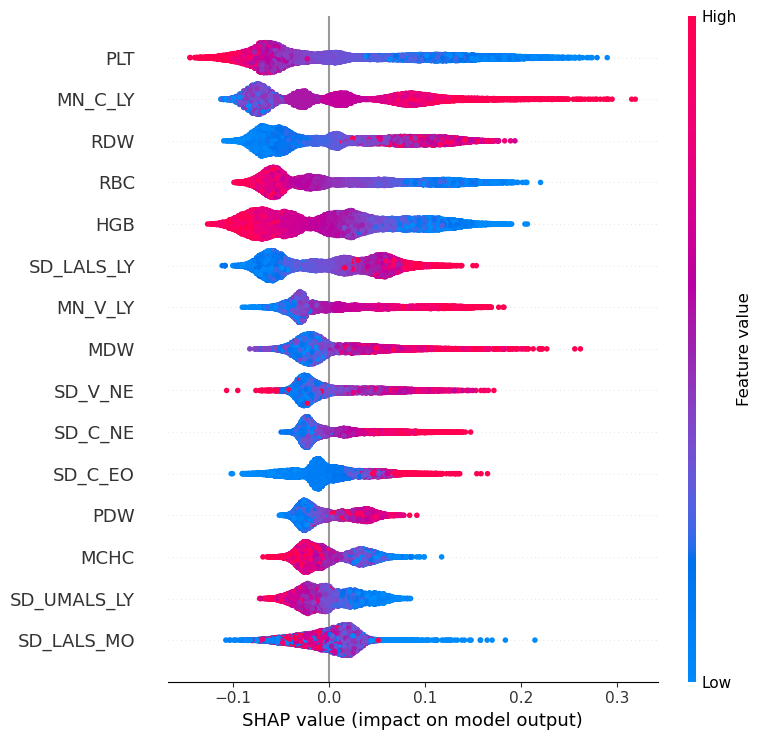

In [25]:

target_class=2

shap_values_target_class = shap_values[:, target_class, :-1]

shap.summary_plot(shap_values_target_class, features=x_train_scale, feature_names=x_train_scale.columns, max_display=15)

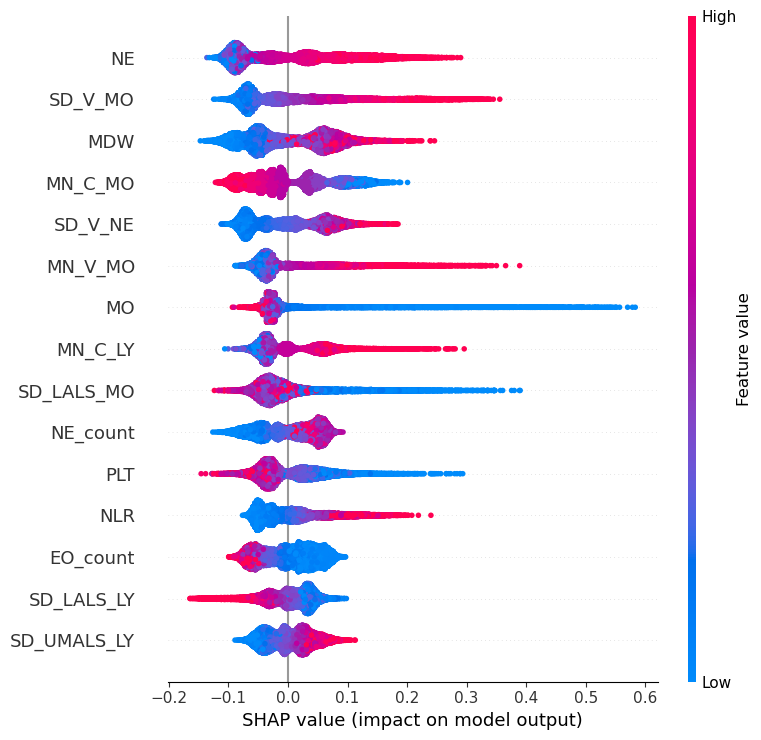

In [26]:

target_class=1

shap_values_target_class = shap_values[:, target_class, :-1]

shap.summary_plot(shap_values_target_class, features=x_train_scale, feature_names=x_train_scale.columns, max_display=15)

## **Plot**

#### **AUROC and AUPRC**

In [37]:
def plot_multiclass_roc(y_true, y_prob, class_names):
    plt.figure(figsize=(6, 6), dpi=600)
    for i, class_name in enumerate(class_names):
        y_true_bin = (y_true == i).astype(int)
        fpr, tpr, _ = roc_curve(y_true_bin, y_prob[:, i])
        auc = roc_auc_score(y_true_bin, y_prob[:, i])
        plt.plot(fpr, tpr, label=f'{class_name} (AUROC={auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='by chance')

    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('AUROC - Development Cohort', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 繪製 AUPRC
def plot_multiclass_prc(y_true, y_prob, class_names):
    plt.figure(figsize=(6, 6), dpi=600)
    for i, class_name in enumerate(class_names):
        y_true_bin = (y_true == i).astype(int)
        precision, recall, _ = precision_recall_curve(y_true_bin, y_prob[:, i])
        ap = average_precision_score(y_true_bin, y_prob[:, i])
        plt.plot(recall, precision, label=f'{class_name} (AUPRC={ap:.3f})')

    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('AUPRC - Development Cohort')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
class_names = ['Nonbacteremia', 'Gram-negative bacteremia', 'Gram-positive bacteremia']

plot_multiclass_roc(y_val, y_prob, class_names)
plot_multiclass_prc(y_val, y_prob, class_names)

#### **Calibration**

In [48]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

def plot_combined_calibration_curve(y_bins_list, y_probs_list, labels, num_classes=3):
    class_titles = {
       0: 'Calibration Plot of Non-Bacteremia Prediction',
       1: 'Calibration Plot of Gram Negative Bacteremia Prediction',
       2: 'Calibration Plot of Gram Positive Bacteremia Prediction'
   }   

    for class_idx in range(num_classes):
        plt.figure(figsize=(10, 8),  dpi=600)
        for i in range(len(y_bins_list)):
            y_bin = y_bins_list[i]
            y_prob = y_probs_list[i]
            brier_score = brier_score_loss(y_bin[:, class_idx], y_prob[:, class_idx])
            
            # Calculate the calibration curve
            fraction_of_positives, mean_predicted_value = calibration_curve(y_bin[:, class_idx], y_prob[:, class_idx], n_bins=10)
            
            # Plot the calibration curve
            plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{labels[i]} - (Brier score: {brier_score:.3f})")
    
        plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        title_str = class_titles.get(class_idx, f"Calibration Plot - Class {class_idx}")

        
        plt.title(title_str, fontsize=18)
        plt.xlabel("Mean predicted value", fontsize=14)
        plt.ylabel("Fraction of positives", fontsize=14)
        plt.xlim(-0.05, 1.05)
        plt.ylim(-0.05, 1.05)
        plt.legend(loc='best', fontsize=15)
        plt.grid(True, which='major', linestyle='--', linewidth=0.7, color='gray')

        plt.show()


In [ ]:
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_wk_bin = label_binarize(y_wk, classes=[0, 1, 2])
y_an_bin = label_binarize(y_an, classes=[0, 1, 2])

y_bins = [y_val_bin, y_test_bin, y_wk_bin, y_an_bin]
y_probs = [y_prob, y_test_prob, y_wk_prob, y_an_prob]
labels = ["CMUH development", "CMUH validation", "WMH validation", "ANH validation"]

plot_combined_calibration_curve(y_bins, y_probs, labels, num_classes=3)